# Evaluate Effect of Parallelism
Show the effect of increasing the number of node replicas on training rate

In [1]:
%matplotlib inline
from jcesr_ml.benchmark import load_benchmark_data
from jcesr_ml.mpnn import set_custom_objects, run_model
from keras.models import load_model
from matplotlib import pyplot as plt
from matplotlib import cm
import pickle as pkl
import pandas as pd
import numpy as np
import json
import os

Using TensorFlow backend.


In [2]:
set_custom_objects()

Configuraiton

In [3]:
model_list = ['single-task', 'multi-task', 'dielectric-constant-softplus', 'dielectric-constant-mpnn-charges']

## Load in the Data
We need a list of models and paths to their output directories and benchmarking datasets.

In [4]:
models = pd.read_json('mpnn-results.json')

In [5]:
_, test_data = load_benchmark_data()

In [6]:
def eval_solv_model(desc):
    """Computes the water outputs for a certain model
    
    Args:
        desc (dict): Model configuration
    Returns:
        (ndarray) Show the 
    """
    
    # Check if network name is in the description
    if 'network' not in desc:
        raise ValueError('`network` must be included in the model configuration')
        
    # Load in the converter
    conv_path = os.path.join('networks', desc['network'], 'converter.pkl')
    with open(conv_path, 'rb') as fp:
        conv = pkl.load(fp)
        
    # Determine which output is water
    with open(os.path.join('networks', desc['network'], 'options.json')) as fp:
        options = json.load(fp)
    output = options['output_props']
    
    # Find the desired model
    query = ' and '.join(f'{k}=="{v}"' for k, v in desc.items())
    hits = models.query(query)
    if len(hits) > 1:
        raise ValueError(f'Found more than one match: {hits["path"].tolist()}')
    elif len(hits) == 0:
        raise ValueError(f'No such model for query: {query}')
    model_info = hits.iloc[0]
    print(f"{model_info['network']} - Finished: {model_info['finished']}")
    model = load_model(os.path.join(model_info['path'], 'best_model.h5'))
    
    # Run in on the target data
    pred_y = run_model(model, conv, test_data['smiles_0'], n_jobs=4, chunk_size=2048)
    
    return pred_y[:, output.index('sol_water')]

## Run the Models
Get the predictions for each point in the test set

In [7]:
for m in model_list:
    test_data[f'sol_water_{m}'] = eval_solv_model({'network': m, 'entries': 117232, 'batch_size': 16384})

single-task - Finished: True
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/home/wardlt/miniconda3/envs/jcesr_ml/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


multi-task - Finished: True
dielectric-constant-softplus - Finished: True
dielectric-constant-mpnn-charges - Finished: False
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Compute KDE for the single task model energy

Text(0, 0.5, 'Frequency')

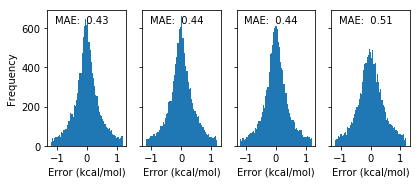

In [8]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(6.5, 2.5))

bins = np.linspace(-1.2, 1.2, 64)
for m, ax in zip(model_list, axs):
    error = test_data[f'sol_water_{m}'] - test_data['sol_water']
    mae = error.abs().mean()
    ax.text(0.1, 0.9, f'MAE: {mae: .2f}', transform=ax.transAxes)
    ax.hist(error, bins=bins)
    ax.set_xlabel('Error (kcal/mol)')
    
axs[0].set_ylabel('Frequency')

Compute the CDF for each of the models